In [1]:
from IPython.display import clear_output

!wget -O event_log.xes https://www.dropbox.com/scl/fi/3t71g6rg5expbrnhc9xzh/Hospital-Billing-Event-Log.xes?rlkey=6t9a67dbcc203y64c2ciax0tm&dl=1

clear_output()
print("Log loaded.")

Log loaded.


In [2]:
!pip install mpvis
!pip install pm4py

clear_output()
print("Packages installed.")

Packages installed.


In [3]:
import mpvis
from mpvis import mddrt
from mpvis import mpdfg
import pm4py
import pandas as pd
from datetime import datetime
from IPython.display import SVG, display
clear_output()

In [4]:
event_log = pm4py.read_xes('event_log.xes')

log_format = {'case:concept:name': 'case:concept:name',
              'concept:name': 'concept:name',
              'time:timestamp': 'time:timestamp',
              'start_timestamp': '',
              'org:resource': 'org:resource',
              'cost:total': ''}

event_log = mpvis.log_formatter(event_log.copy(), log_format)

parsing log, completed traces ::   0%|          | 0/100000 [00:00<?, ?it/s]

In [5]:
print("Case count: " + str(len(set(event_log['case:concept:name']))))
print("Variant count: " + str(len(pm4py.stats.get_variants(event_log.copy()))))
print("Event count: " + str(len(event_log['case:concept:name'])))
print("Activity count: " + str(len(set(event_log['concept:name']))))

Case count: 100000
Variant count: 1020
Event count: 451359
Activity count: 18


In [6]:
mpdfg_discovery_start = datetime.now()

dfg, start_activities, end_activities = mpdfg.discover_multi_perspective_dfg(event_log.copy())

mpdfg_discovery_end = datetime.now()

print("MP-DFG discovery time: " + str((mpdfg_discovery_end - mpdfg_discovery_start).total_seconds()) + " seconds.")

MP-DFG discovery time: 130.79014 seconds.


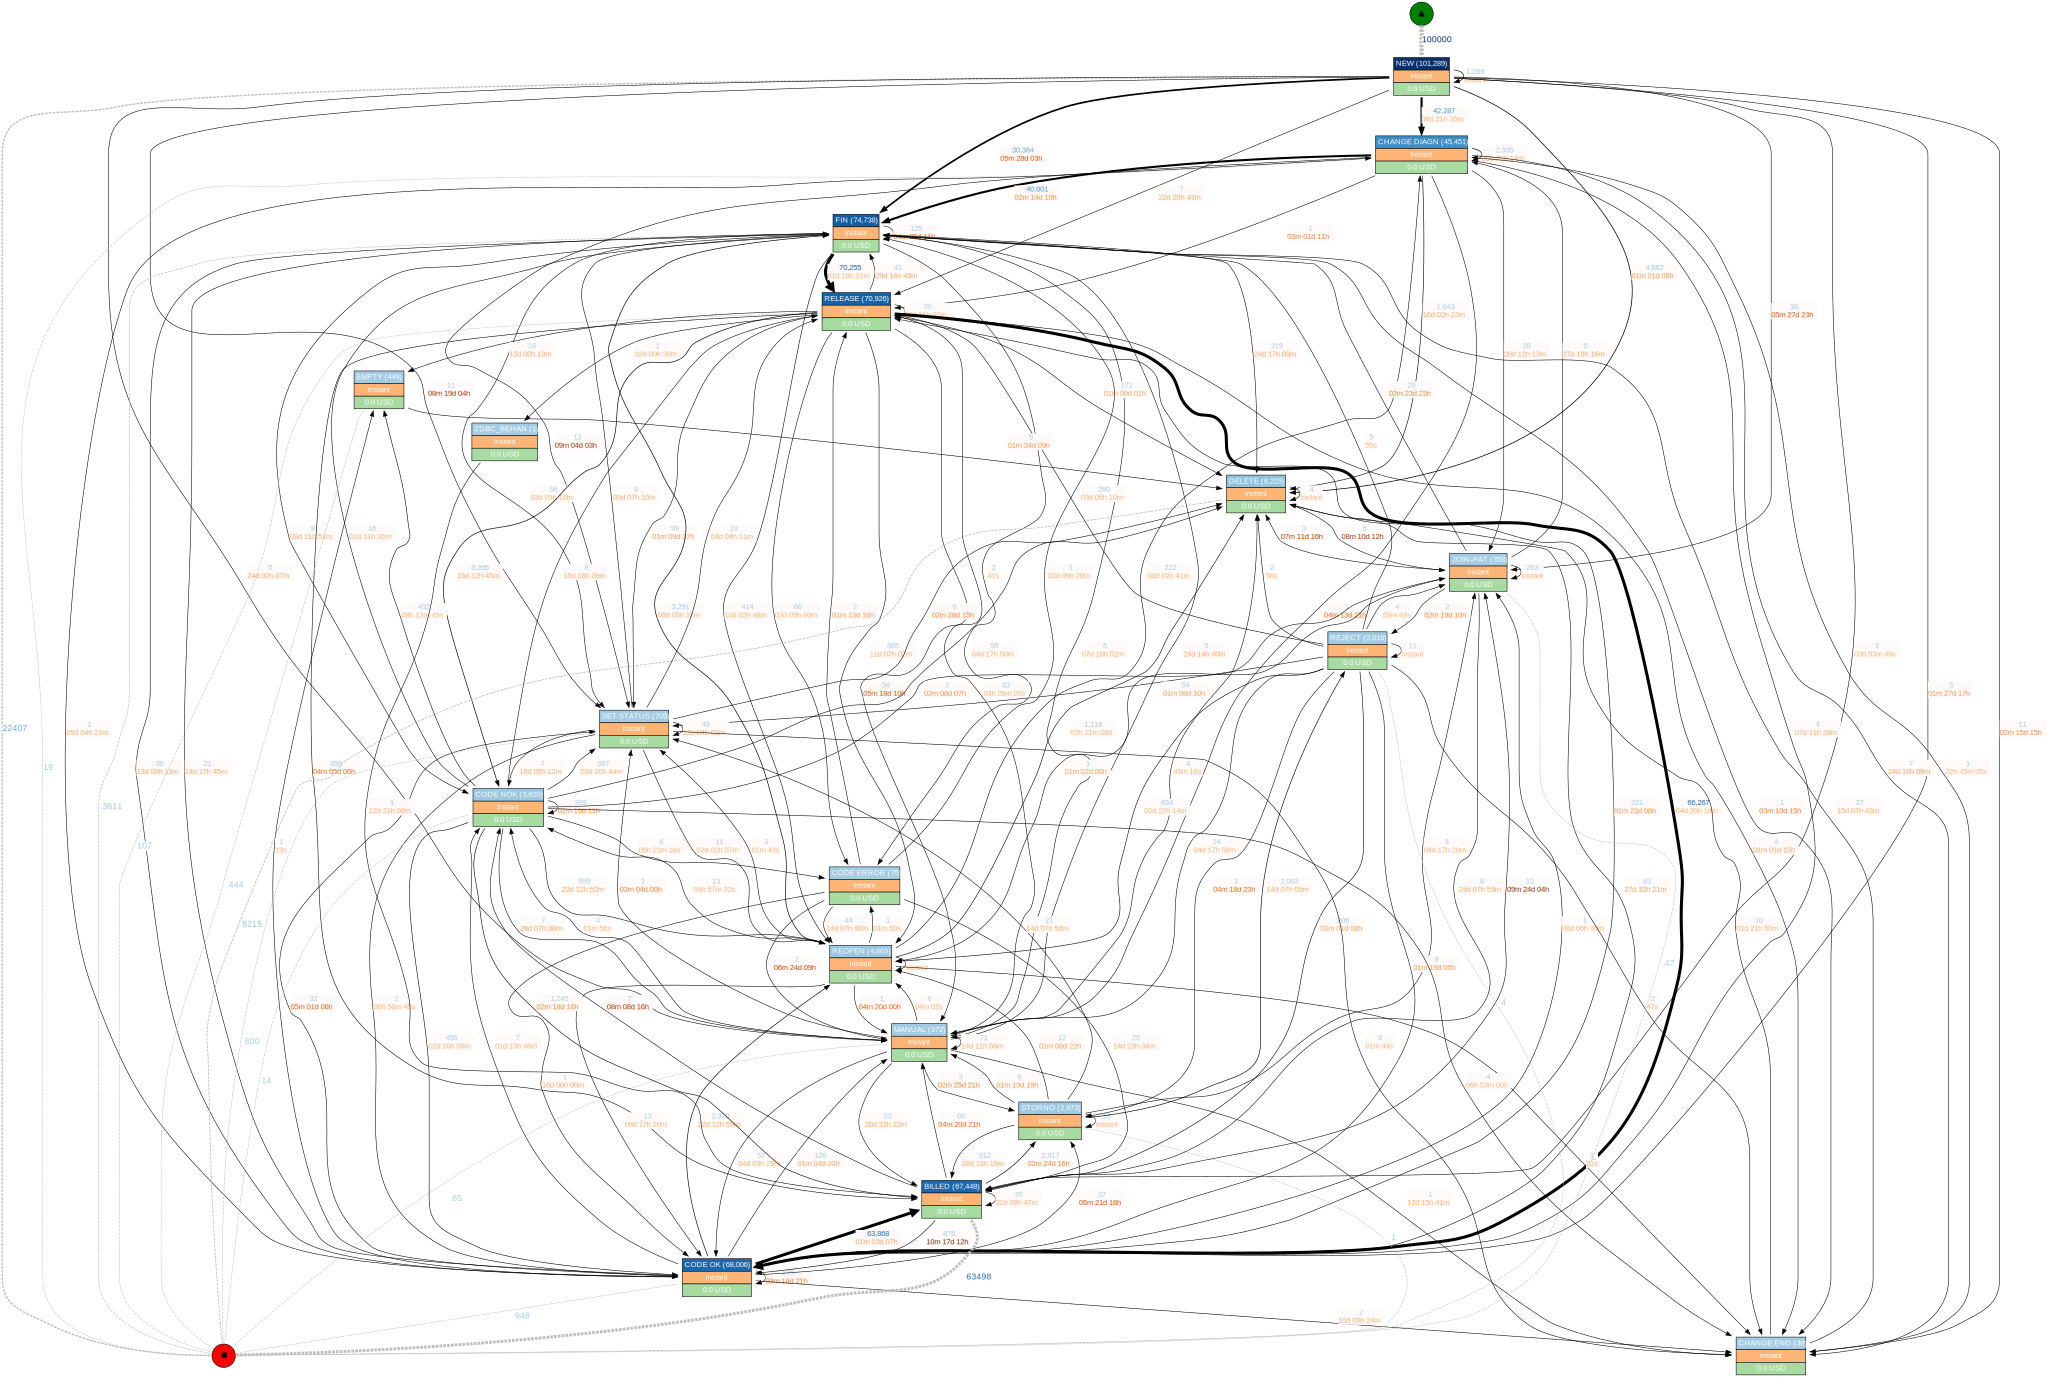

In [7]:
mpdfg_visualization_start = datetime.now()

mpdfg.view_multi_perspective_dfg(dfg, start_activities, end_activities)

mpdfg_visualization_end = datetime.now()

print("MP-DFG visualization time: " + str((mpdfg_visualization_end - mpdfg_visualization_start).total_seconds()) + " seconds.")

In [8]:
mddrt_discovery_start = datetime.now()

drt = mddrt.discover_multi_dimensional_drt(event_log.copy())

mddrt_discovery_end = datetime.now()

print("MD-DRT discovery time: " + str((mddrt_discovery_end - mddrt_discovery_start).total_seconds()) + " seconds.")

MP-DFG visualization time: 0.905007 seconds.
Calculating log mandatory activities: 


100%|██████████| 100000/100000 [1:37:21<00:00, 17.12it/s]


Calculating log metrics: 


100%|██████████| 100000/100000 [1:36:22<00:00, 17.29it/s]


Building Tree Cases:


100%|██████████| 100000/100000 [53:34<00:00, 31.11it/s]


Building Tree Graph:


100%|██████████| 100000/100000 [00:09<00:00, 10579.55it/s]


MD-DRT discovery time: 14853.109034 seconds.


In [9]:
mddrt_visualization_start = datetime.now()

mddrt.view_multi_dimensional_drt(drt)

mddrt_visualization_end = datetime.now()

print("MD-DRT visualization time: " + str((mddrt_visualization_end - mddrt_visualization_start).total_seconds()) + " seconds.")

Output hidden; open in https://colab.research.google.com to view.

In [10]:
print("MP-DFG discovery time: " + str((mpdfg_discovery_end - mpdfg_discovery_start).total_seconds()) + " seconds.")
print("MP-DFG visualization time: " + str((mpdfg_visualization_end - mpdfg_visualization_start).total_seconds()) + " seconds.")
print("MD-DRT discovery time: " + str((mddrt_discovery_end - mddrt_discovery_start).total_seconds()) + " seconds.")
print("MD-DRT visualization time: " + str((mddrt_visualization_end - mddrt_visualization_start).total_seconds()) + " seconds.")

MP-DFG discovery time: 130.79014 seconds.
MP-DFG visualization time: 0.905007 seconds.
MD-DRT discovery time: 14853.109034 seconds.
MD-DRT visualization time: 21.202133 seconds.


In [11]:
# A copy of the original log is used to allow comparing the processed and original logs
processed_log = event_log.copy()

In [12]:
# The original log contains several cases that seem to be incomplete (e.g., they do not start or end with a valid activity)
# Only cases that start with 'NEW' and that end with 'BILLED' will be considered
processed_log = pm4py.filter_start_activities(processed_log, ['NEW'])
processed_log = pm4py.filter_end_activities(processed_log, ['BILLED'])

print("Case count before: " + str(len(set(event_log['case:concept:name']))))
print("Case count after: " + str(len(set(processed_log['case:concept:name']))))

Case count before: 100000
Case count after: 63498


In [13]:
# Several of the activities in the event log occur less than 1% of the time
# These activities are removed, as their inclusion increases the variant count considerably
processed_log = pm4py.filter_event_attribute_values(processed_log, 'concept:name', ['CHANGE END', 'CODE ERROR', 'CODE NOK', 'DELETE', 'EMPTY', 'JOIN-PAT', 'MANUAL', 'REJECT', 'REOPEN', 'SET STATUS', 'STORNO', 'ZDBC_BEHAN'], level = 'event', retain = False)

print("Variant count before: " + str(len(pm4py.stats.get_variants(event_log.copy()))))
print("Variant count after: " + str(len(pm4py.stats.get_variants(processed_log.copy()))))

Variant count before: 1020
Variant count after: 350


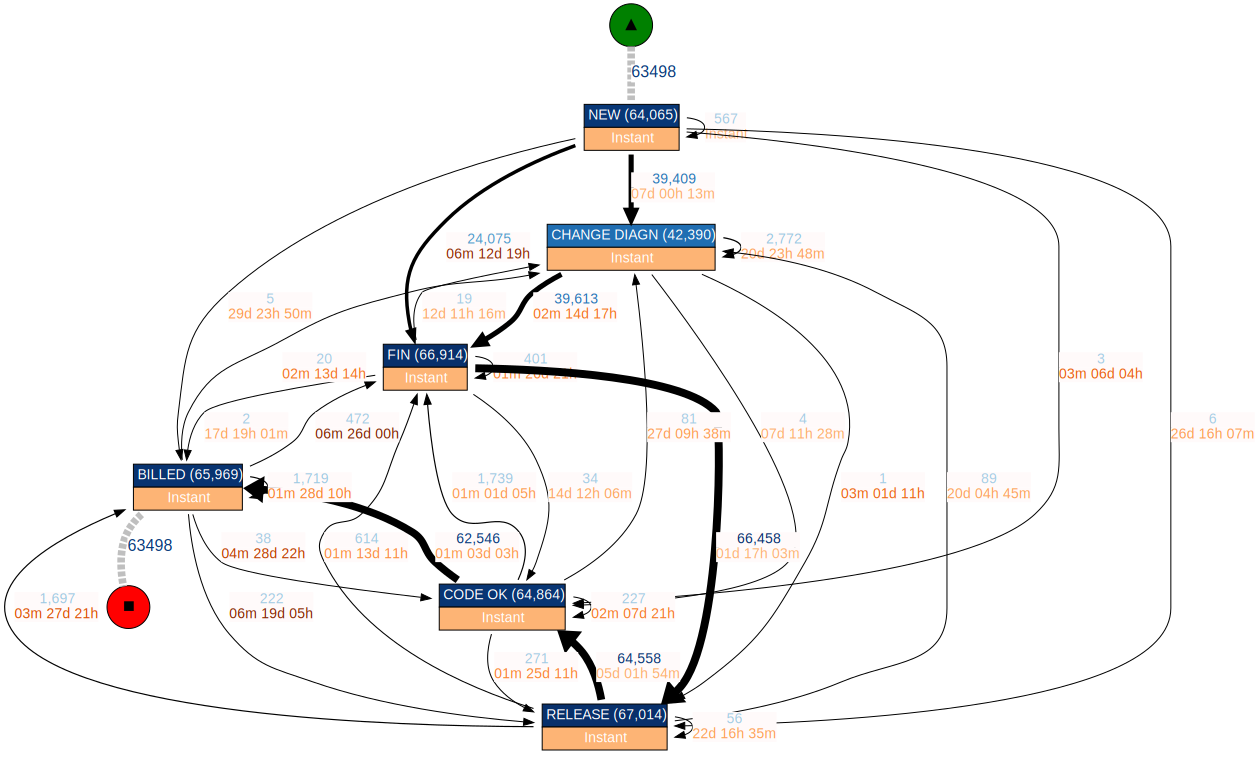

In [14]:
dfg, start_activities, end_activities = mpdfg.discover_multi_perspective_dfg(processed_log.copy())

mpdfg.save_vis_multi_perspective_dfg(dfg, start_activities, end_activities, file_name = 'dfg_processed_log_100_100', format = 'svg', visualize_cost = False)
display(SVG(filename = 'dfg_processed_log_100_100.svg'))

Calculating log mandatory activities: 


100%|██████████| 62743/62743 [47:30<00:00, 22.01it/s]


Calculating log metrics: 


100%|██████████| 62743/62743 [48:04<00:00, 21.75it/s]


Building Tree Cases:


100%|██████████| 62743/62743 [23:41<00:00, 44.14it/s]


Building Tree Graph:


100%|██████████| 62743/62743 [00:06<00:00, 10322.83it/s]


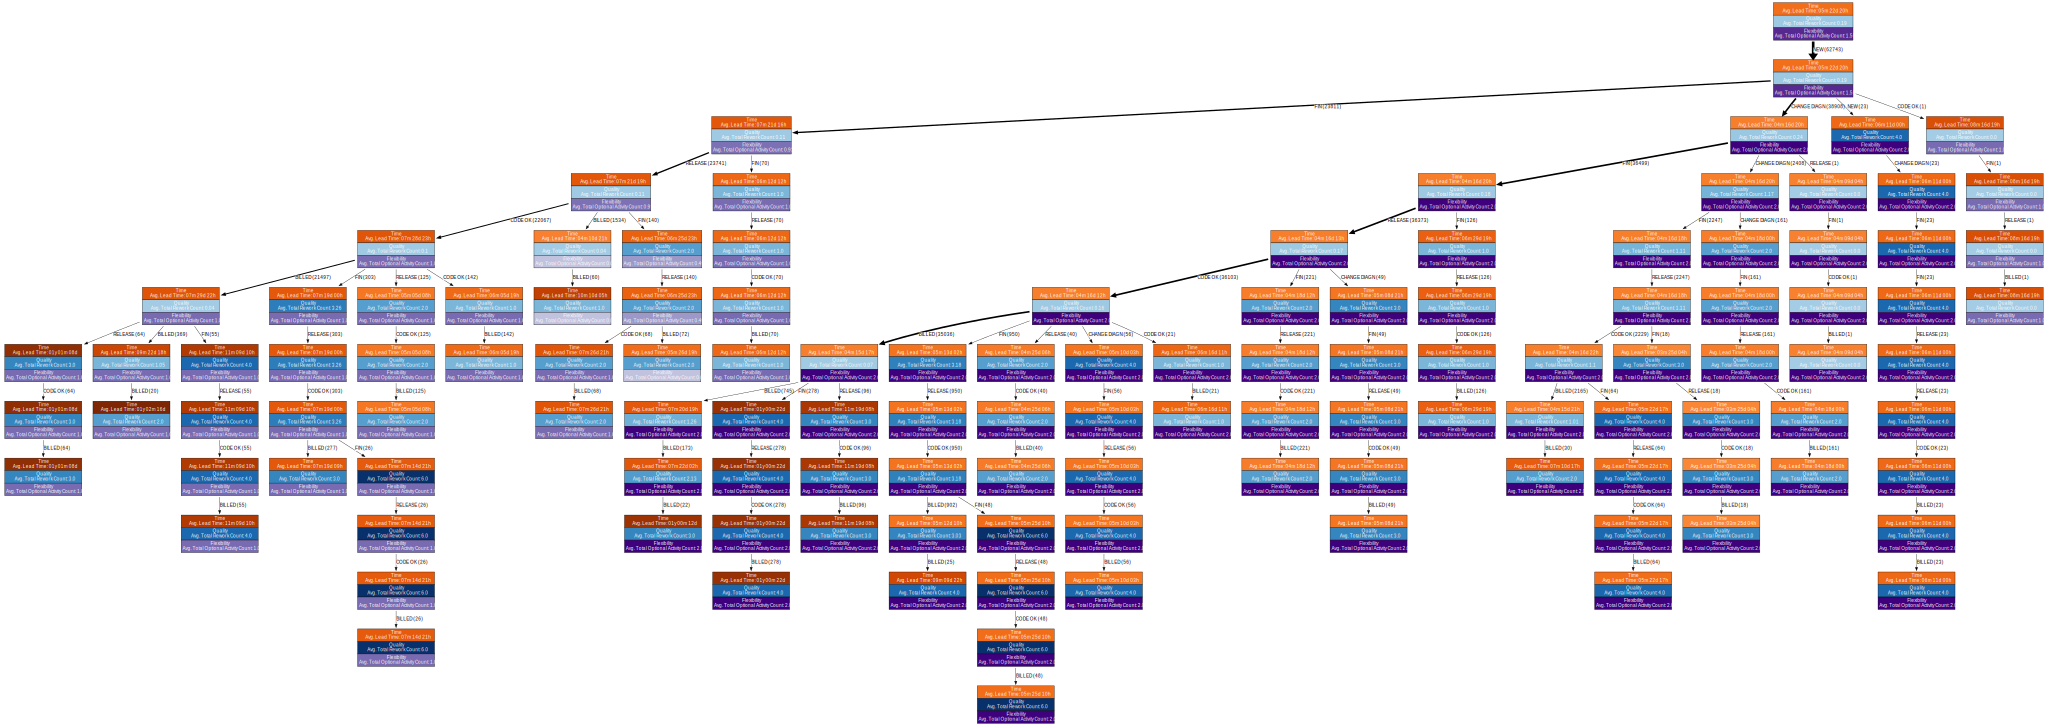

In [15]:
# Since some variants of the process rarely occur (i.e., less than 12 times), only the 10% most common variants are considered
pruned_log = mpvis.preprocessing.prune_log_based_on_top_variants(processed_log.copy(), k = 35)

drt = mddrt.discover_multi_dimensional_drt(pruned_log.copy())
mddrt.save_vis_multi_dimensional_drt(drt, file_path = 'drt_processed_log_10_variants', visualize_cost = False)
display(SVG(filename = 'drt_processed_log_10_variants.svg'))